The dataset I will be analysing contains statistics for arrests per 100,000 residents, for assault, murder and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.

In [217]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from pca import pca

from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as staticmethod

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import warnings
warnings.filterwarnings('ignore')

In [218]:
# Load in the data
df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [219]:
# Rename City column to State
df.rename(columns={'City': 'State'}, inplace=True)

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [221]:
# Make numerical features type float
df['Assault']= df['Assault'].astype('float64')
df['UrbanPop']= df['UrbanPop'].astype('float64')
df.dtypes

State        object
Murder      float64
Assault     float64
UrbanPop    float64
Rape        float64
dtype: object

In [222]:
# Check for missing values
df.isnull().sum()

State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [223]:
# Perform a statistical summary of the dataset
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


DATA SUMMARY: 
From the above we can see that the 'Murder' feature ranges from 0.8 to 17.4 cases per 100,000 residents with a mean of 7.788. The 'Assault' feature ranges from 34 too 337 cases per 100,000 residents with a mean of 170.76. The 'Rape' feature ranges from 7.3 to 46 cases per 100,000 residents with a mean of 21.232. The 'UrbanPop' feature ranges from 32% to 91% of the total population for each state living in urban areas with a mean of 65.54%.
We can also see that there are no missing values in the dataset.

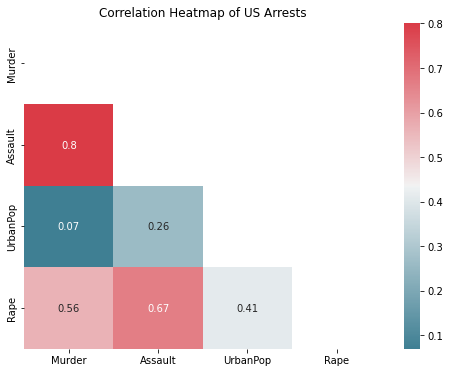

In [224]:
# Looking at how our features correlate with one another
plt.figure(figsize=(8,6))
Arrest_corr = df.corr()

# mask the mirror side of the heatmap
dropmirror = np.zeros_like(Arrest_corr)
dropmirror[np.triu_indices_from(dropmirror)]= True

colormap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(Arrest_corr, annot=True, mask=dropmirror, cmap=colormap)
plt.title('Correlation Heatmap of US Arrests')
plt.show()


From the above heatmap showing the correlation between the data features, we can see that all the correlations are positive. 'Assault' and 'Murder' are the most highly correlated with a coefficient of 0.8.

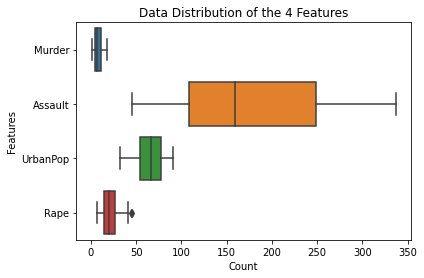

In [225]:
# Create a boxplot for feature distribution
sns.boxplot(data=df, orient='h')
plt.ylabel('Features')
plt.xlabel('Count')
plt.title('Data Distribution of the 4 Features')
plt.show()

Looking at the above box plot showing the distribuition of the data, we can see that the features have very different scales to one another.

DATA SCALING: We need to scale the data before continuing with PCA because the features are very different in terms of their scale and distribution

In [226]:
# Select independent features and standardize them
scaled = StandardScaler().fit_transform(df.iloc[:,1:5])

#create scaled version of the DataFrame
df_scale = pd.DataFrame(scaled, columns = df.columns[1:5])
df_scale.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


APPLY PCA: This is done to potentially reduce the number of data dimensions. There are currently 4 features so we will start with 4 principal components and see if they are all necessary in order to provide useful insights about the data.

In [227]:
# Showing how each component attributes itself to the explained variance
pca = PCA().fit(df_scale)
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

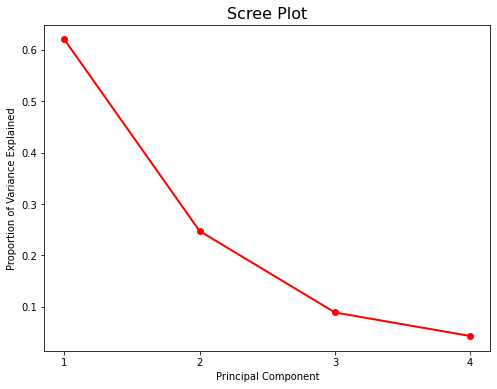

In [228]:
# Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, "ro-", linewidth=2)

# Add title and labels
plt.title("Scree Plot", size=16)
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
# Correct xticks
plt.xticks(range(4), [i+1 for i in range(4)])
plt.show()

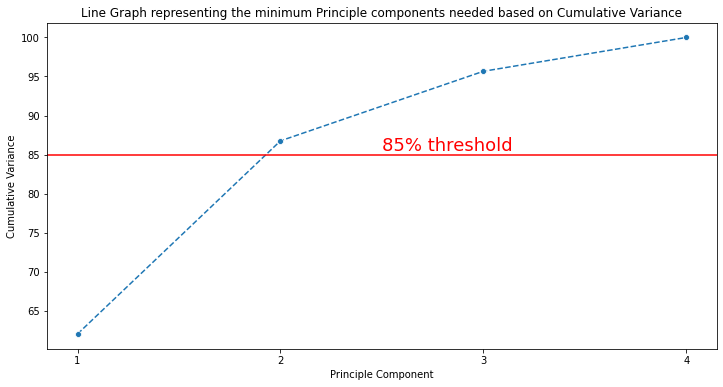

In [229]:
# Creating a graph to show the minimum number of components needed for our analysis
X = np.arange(1, 5, step=1)

plt.figure(figsize=(12,6))
sns.lineplot(x=X, y=np.cumsum(pca.explained_variance_ratio_)*100, linestyle='--', marker='o')

plt.title('Line Graph representing the minimum Principle components needed based on Cumulative Variance')
plt.xlabel('Principle Component')
plt.xticks(np.arange(1, 5, step=1))
plt.ylabel('Cumulative Variance')
plt.axhline(y=85, color='r', linestyle='-')
plt.text(2.5, 85.5, '85% threshold', color = 'red', fontsize=18)
plt.show()


The above graph and explained variance ratios tell us that component 1 contains 62% of all explained variances within our data. Component 2 contains 24.74% of all explained variances. Adding all this up we find that with 2 Principal components we achieve an explanation of variance within our data of 86.74%. So, effectively we could get rid of 50% of the data yet be able to maintain a 86.74% explanation value as to how our features deviate or affects one another.

In [230]:
# Proceeding with 2 principal components 
pca = PCA(n_components = 2)

PC = pca.fit_transform(df_scale)

PC.shape

(50, 2)

So now we have 2 principal components to represent the data, we create a new dataframe including the State so we can plot the data again. This will be our dataset for the clustering analysis.

In [231]:
# transform the components into a pandas data frame
df_pca = pd.DataFrame(data=PC, index=df['State'], columns=['Principal Component 1', 'Principal Component 2'])
df_pca.head()

,Principal Component 1,Principal Component 2
State,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


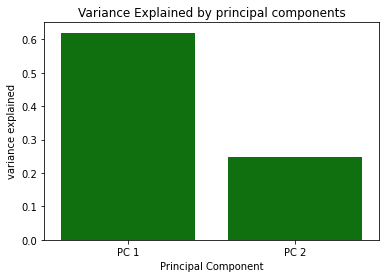

In [232]:
# Creating a barplot to visually represent how each component affects the variance
df_var = pd.DataFrame({'variance explained': pca.explained_variance_ratio_, 'Principal Component': ['PC 1', 'PC 2']})

plt.title('Variance Explained by principal components')
sns.barplot(x='Principal Component', y='variance explained', data=df_var, color='g')
plt.show()

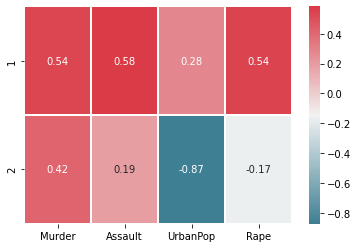

In [233]:
# Sets colour of heatmap  
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Determine the significance of feature to principal components
components = pd.DataFrame(pca.components_, columns = df.columns[1:]
                         , index = [1,2])

ax = sns.heatmap(components,cmap=colormap,
                 linewidth=1.8, annot = True)

The above heatmap shows the correlation of the feature components with the two principal components. All the feature components have a postive correlation with the first principle component. In particular, 'Murder, 'Assault' and 'Rape' have signficant postive correlations with the first principal component

Hierarchical Clustering: 

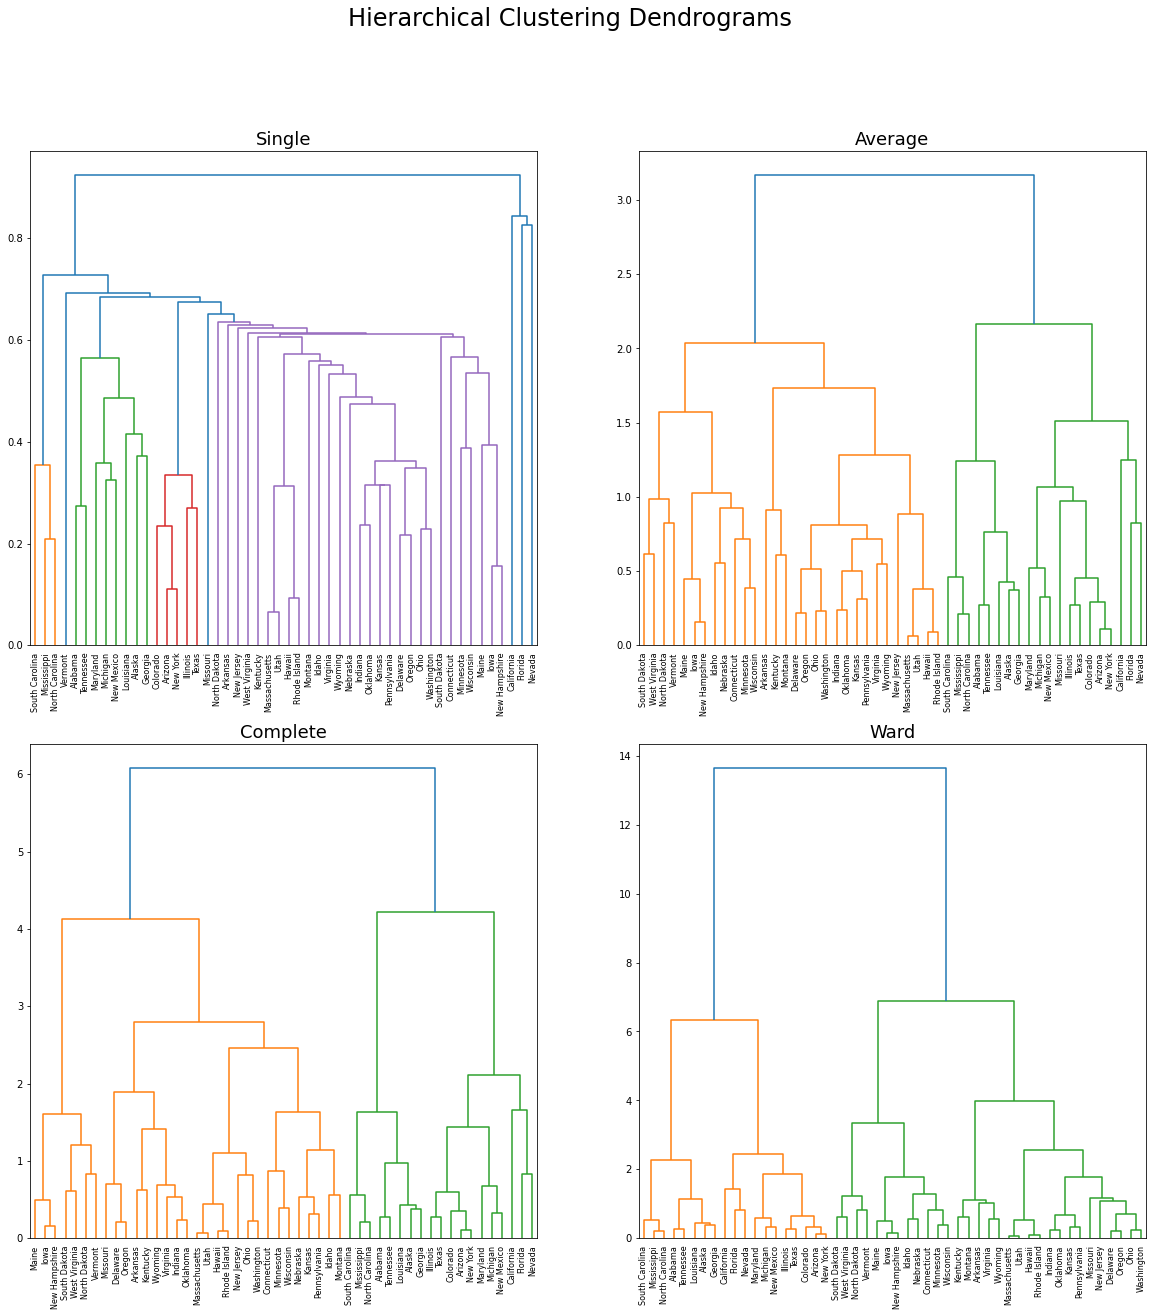

In [234]:
# Initialise an agglomerative clustering model and fit to PCA data
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(df_pca)

# Plot dendrograms for each linkage method
fig, axs = plt.subplots(2, 2, figsize= (20,20))
# Add overall title
fig.suptitle("Hierarchical Clustering Dendrograms", fontsize=24)

# PLot individual dendrograms and titles
axs[0][0].set_title("Single", fontsize=18)
dendrogram(linkage(df_pca, method="single"), labels=df_pca.index, ax=axs[0][0])
axs[0][1].set_title("Average", fontsize=18)
dendrogram(linkage(df_pca, method="average"), labels=df_pca.index, ax=axs[0][1])
axs[1][0].set_title("Complete", fontsize=18)
dendrogram(linkage(df_pca, method="complete"), labels=df_pca.index, ax=axs[1][0])
axs[1][1].set_title("Ward", fontsize=18)
dendrogram(linkage(df_pca, method="ward"), labels=df_pca.index, ax=axs[1][1])

plt.show()

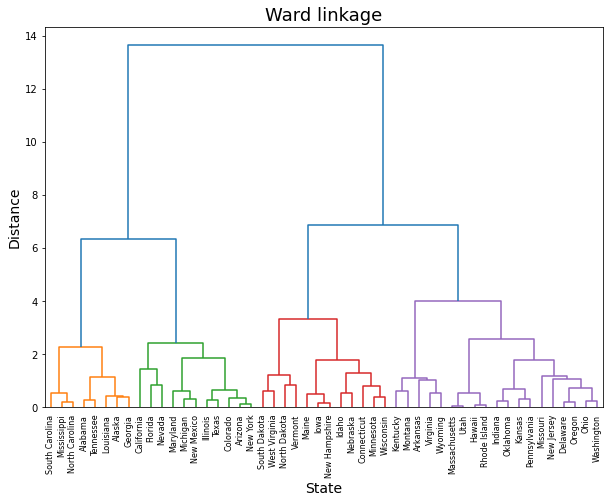

In [235]:
# Plot clearer dendrogram for ward linkage
plt.figure(figsize=(10, 7))

dendrogram(linkage(df_pca, method='ward'), labels=df_pca.index, color_threshold=6)

# Add axis labels
plt.xlabel("State", size=14)
plt.ylabel("Distance", size=14)
# Add title and show
plt.title("Ward linkage", size=18)
plt.show()

K-Means Clustering:
We will cluster the data into 2 clusters, as suggested by the Ward dendrogram. We will extract the first 2 principal components from the PCA dataframe and then plot our data relative to these as they are the components that explain the most variance in the data.

In [236]:
# Extract the first two principal components for plotting
pc_1 = df_pca['Principal Component 1']
pc_2 = df_pca['Principal Component 2']

# Fit a k-means estimator
k = 2  # From dendrogram clusters
kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=23)

# Get cluster labels and cluster centers
cluster_labels = kmeans.fit_predict(df_pca)
centers = kmeans.cluster_centers_

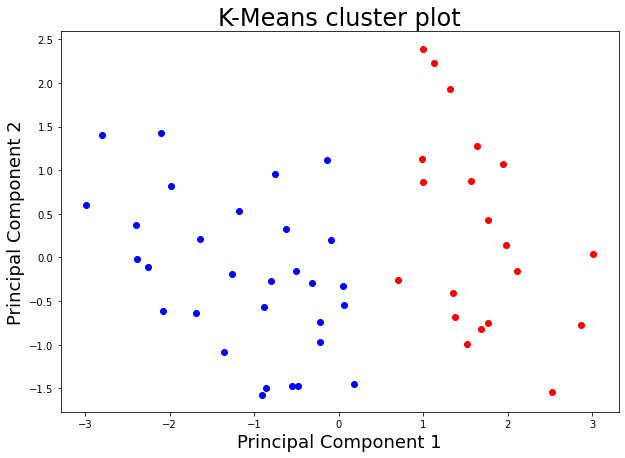

In [237]:
# Plot clusters
fig, ax = plt.subplots(figsize=(10,7))
# Define colours
colours = "rbgy"
# Plot each cluster
for i in range(k):
    ax.scatter(pc_1[cluster_labels == i], pc_2[cluster_labels == i],c = colours[i])

# Add title, and labels, and show
ax.set_title("K-Means cluster plot", size=24)
ax.set_xlabel("Principal Component 1", size=18)
ax.set_ylabel("Principal Component 2", size=18)

plt.show()

Summary:
In this task, I have  investigated the differences between arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas. This was conducted using Principal Component Analysis (PCA) and various clustering techniques. PCA resulted in the dataset reducing to two principcal components (PC).
Results showed that PC1 had a positive correlation to all the features in the dataset. Most notably, 'Rape', 'Assault' and 'Murder'. For PC2, the only significant relationship it had was with one feature, 'UrbanPop' and it was a negative correlation.
On the cluster scatter graph, The first cluster data points all had positive PC1 values. This suggests that for this cluster, the arrests are mainly attributed to 'Rape', 'Assault' and 'Murder'.
The second cluster data points mainly had negative PC1 values and majority negative PC2 values. This suggests that for this cluster, the arrests are mainly attributed to a high percentage of the population living in urban areas.